In [24]:
# Import packages and other setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import datetime as dt
from sklearn.metrics import mean_squared_error
from scipy import stats
import pickle
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.integrate as integrate
from bisect import bisect_left
import random
import itertools

In [2]:
plt.rcParams['figure.figsize'] = (15,10)
sns.set()

In [4]:
#ex. post optimal strategy
def hindsight_strategy(df, budget = 15):		
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
    df = df.sort_values(by = 'bang_per_buck', ascending=False)
    df['utility'] = 0
    df['won'] = False
    df['spend'] = 0
    shade = 1.0
    for index,row in df.iterrows():
        if budget-row['competing_bid'] >=0 and row['bang_per_buck']>0:
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            if row['competing_bid']==0:
                shade = np.infty
            else:
                shade = row['value']/row['competing_bid']
            budget = budget - row['competing_bid']
            df.loc[index] = row
        else:
            break
    #print(shade)
    df['paced_bid'] = df['value']/shade
    df.sort_index(inplace=True)
    df['spend'] = df['competing_bid']*df['won']
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    df['pacing_multiplier'] = 1.0/shade
    #print(df.head())
    return df

In [6]:
#No regret adaptive pacing strategy
def adaptive_pacing_bg(df, target_spend, learning_rate = 0.001):
    """ A function to simulate an adaptive pacing strategy which attempts match the target spend

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        target_spend: instantaneous target spend (not cumulative)

    Returns:
        A dataframe containing with the following columns for each impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        target_spend: Target spend rate in this round
        utility: Utility obtained in this round
        paced_bid: Paced impression bid
        value_obtained: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data
    """
        
    max_shading = 100
    budget = np.sum(target_spend)
    cur_shading = 0.01
    df['pacing_multiplier'] = 0
    df['utility'] = 0
    df['won'] = False
    df['target_spend'] = target_spend
    df['paced_bid'] = 0
    df['spend'] = 0
    for index,row in df.iterrows():
        row['paced_bid'] = min(row['value']/(1 + cur_shading), budget)
        if row['paced_bid']==0:
            row['pacing_multiplier'] = 0
        else:
            row['pacing_multiplier'] = row['paced_bid']/row['value']
        if row['paced_bid']>=row['competing_bid']:
            budget = budget - row['competing_bid']
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            row['spend'] = row['competing_bid']
        cur_shading = cur_shading - learning_rate*(row['target_spend']-row['spend'])
        cur_shading = np.clip(cur_shading, a_min = 0, a_max = max_shading)
        df.loc[index] = row
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    #print(df.head())
    return df

In [7]:
#ex. post optimal strategy
def truthful_bidding(df, budget):
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
    df['utility'] = 0
    df['won'] = False
    df['spend'] = 0
    for index,row in df.iterrows():
        if budget-row['competing_bid'] >=0 and row['bang_per_buck']>0:
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            budget = budget - row['competing_bid']
            df.loc[index] = row
    #print(shade)
    df['paced_bid'] = df['value']
    df['spend'] = df['competing_bid']*df['won']
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    df['pacing_multiplier'] = 1.0
    #print(df.head())
    return df

# Spend rate estimation fixed price

In [252]:
def estimate_spend_rate(df_samples, budget, num_episodes, T):
    df = df_samples.copy()
    df['episode'] = np.repeat(range(num_episodes),df_samples.shape[0]/num_episodes)
    df['bang_per_buck'] = df['value']/df['competing_bid']
    theta = estimate_theta(df, budget, num_episodes, T)
    spend_rates = np.empty((0))
    spend_rate_ep = np.zeros(num_episodes)
    for e in range(num_episodes):
        df_e = df[df['episode']==e]
        bang_per_buck_cdf_e = ECDF(df_e['bang_per_buck'])
        spend_rate_e = 1 - bang_per_buck_cdf_e(theta)
        spend_rate_ep[e] = spend_rate_e
    spend_rate_ep = spend_rate_ep.clip( min = 1/(num_episodes*100))
    spend_rates = np.repeat(spend_rate_ep,T) 
    spend_sum = np.sum(spend_rates)
    print(spend_rate_ep)
    if spend_sum != 0:
        spend_rates = (spend_rates/spend_sum)*budget
    return spend_rates

In [170]:
def estimate_theta(df, budget, num_episodes, T):
    spend_per_round = budget/(num_episodes*T*df['competing_bid'].iloc[0])
    bang_per_buck_cdf = ECDF(df['bang_per_buck'])
    theta = smallest_x_with_cdf (bang_per_buck_cdf, 1 - spend_per_round)
    return theta

In [171]:
def smallest_x_with_cdf(cdf, cdf_thresh):
    eps = 1e-5
    l = 1.0
    r = 1.0
    while(cdf(r) <= cdf_thresh):
        r = 2*r
    x = (l+r)/2
    while (r-l > eps):
        x = (l+r)/2
        if (cdf(x) > cdf_thresh):
            r = x
        else:
            l = x
    return x

# Spend rate estimation, changing price

In [273]:
def estimate_spend_rate_cp(df_samples, budget, num_episodes, T):
    df = df_samples.copy()
    df['episode'] = np.repeat(range(num_episodes),df_samples.shape[0]/num_episodes)
    bandwidth = 0.1
    eps = 0.001
    episodic_spend_fn = {}
    for e in range(num_episodes):
        episodic_spend_fn[e] = {}
        episodic_spend_fn[e]['episode'] = e
        df_e = df[df['episode']==e]
        episodic_spend_fn[e]['price_kde'] = sm.nonparametric.KDEUnivariate(df_e['competing_bid'])
        episodic_spend_fn[e]['price_kde'].fit(bw=bandwidth)
        episodic_spend_fn[e]['value_ecdf'] = ECDF(df_e['value'])
        episodic_spend_fn[e]['upper_limit'] = episodic_spend_fn[e]['price_kde'].support[-1]
        episodic_spend_fn[e]['spend_bpb']  = lambda x: estimate_spend(episodic_spend_fn[e]['price_kde'],  episodic_spend_fn[e]['value_ecdf'], x, episodic_spend_fn[e]['upper_limit'])
       
        
    spend_per_round = budget/(num_episodes*T)

    
    theta = smallest_bpb_with_spend( lambda x: over_all_spend_bpb(episodic_spend_fn, x, num_episodes) , spend_per_round)
    print("Our multiplier %f"%theta)

    spend_rates = np.empty((0))
    spend_rate_ep = np.zeros(num_episodes)
    for e in range(num_episodes):
        spend_rate_e = episodic_spend_fn[e]['spend_bpb'](theta)
        spend_rate_ep[e] = spend_rate_e

    spend_rate_ep = spend_rate_ep.clip( min = 1/(num_episodes*10))
    for e in range(num_episodes):
        spend_rates = np.append(spend_rates, np.full(T, spend_rate_ep[e]))

    spend_sum = np.sum(spend_rates)
    print("spend_sum = %f"%spend_sum)
    print("budget = %f"%budget)
    if spend_sum != 0:
        spend_rates = (spend_rates/spend_sum)*budget
    return spend_rates

In [274]:
def estimate_spend(price_kde, value_ecdf, bang_per_buck,  h=100):
    if(bang_per_buck < 1):
        bang_per_buck = 1
    spend_p = lambda x: (price_kde.evaluate(x)[0])*x*(1-value_ecdf(bang_per_buck*x))
    return integrate.quad(spend_p, 0, h)[0]

In [275]:
def over_all_spend_bpb(episodic_spend_fn, bang_per_buck, num_episodes):
    spend_c = 0
    for e in range(num_episodes):
        spend_this_episode = estimate_spend(episodic_spend_fn[e]['price_kde'], episodic_spend_fn[e]['value_ecdf'] , bang_per_buck,  episodic_spend_fn[e]['upper_limit'])
        spend_c = spend_c + spend_this_episode
    return spend_c/num_episodes

In [276]:
def smallest_bpb_with_spend(spend_fn, spend):
    eps = 1e-6
    l = 0
    r = 1.0
    cnt = 100
    while(spend_fn(r) > spend and cnt > 0):
        cnt = cnt -1 
        r = 2*r
    x = (l+r)/2
    while (r-l > eps):
        x = (l+r)/2
        if (spend_fn(x) < spend):
            r = x
        else:
            l = x
    return x

## Linear spend rate

In [176]:
def linear_spend_rate(budget, num_rounds):
    """
    Linear OC. Assumes interarrival time between the impressions is uniform.
    
    Args:
        budget: budget to be divided
        num_rounds: number of rounds the budget needs to be divided into

    Returns:
        Linear (OC)
        
    """
    
    return [budget/num_rounds]*num_rounds

In [177]:
def change_OC(df_in):
    df = df_in.copy()
    mapping = {'fixed_p': 'Fixed pacing','lin' : 'Fixed spend (BG19)', 'dist' : 'Changing spend (this)', 'hindsight':'Optimal', 'truthful': 'Truthful'}
    df['Algorithm'] = ""
    for i in range(df_in.shape[0]):
        df['Algorithm'].iloc[i] = mapping[ df['OC'].iloc[i]] 
    return df

## Regret (not used in experiments as of now)

In [178]:
def paced_regret_u(hindsight_df, pacing_df):
    """
    Final utility regret. Returns percent regret measured with respect to the hindsight value
    """
    hindsight_total_val = hindsight_df['utility'].sum()
    paced_total_val = pacing_df['utility'].sum()
    return ((hindsight_total_val - paced_total_val)*100/hindsight_total_val)

# Facebook data

# <span style='color:red'> Change the following 2 functions!!!  </span> 

In [179]:
def get_fb_data(campaigns,num_episodes, T, training_samples_per_episode):
    campaign = random.choice(campaigns)
    print(campaign)
    episode_length_minutes =  (24*60)/num_episodes
    test_data = get_transformed_data_from_campaign(campaign,  T, episode_length_minutes)
    
    training_data = get_transformed_data_from_campaign(campaign, training_samples_per_episode, episode_length_minutes)
    
    return test_data, training_data

### <span style='color:red'> The followig function is just a dummy, use the function that returns fixed impressions per bucket transform instead of following </span> 

In [226]:
def get_transformed_data_from_campaign(campaign,samples_per_episode, episode_length_minutes):
    num_episodes = int((24*60)/episode_length_minutes)
    val = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        val = np.append(val, np.random.uniform( 1 + 0.1*i, 2 + 0.1*i,samples_per_episode))
        #episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = val
    df['competing_bid'] = 1
    #df['episode'] = episode
    return df

In [194]:
campaigns = ['1', '2'] #campaign names as strings

# Experiment script

In [197]:
columns_plot = ['utility', 'spend']

In [277]:
dataset = 'fb_campaigns'
data_oracle = lambda num_episodes, T, training_samples_per_episode: get_fb_data(campaigns,num_episodes, T, training_samples_per_episode)
spend_rate_estimation_oracle = estimate_spend_rate_cp 

## Set num episodes appropriately, maybe 24

In [278]:
T = 100 #Number of impressions in each episode
num_episodes = 10 #Number of episodes
training_samples_per_episode = 100

In [279]:
df_utility_res = {}
df_utility_res[dataset] = pd.DataFrame (columns = ['utility', 'utility_h', 'budget_frac', 'OC']) 

In [280]:
OCs =['truthful','lin','dist']

In [282]:
num_exp = 5 #number of times the experiment to be repeated
learning_rate = 0.1

## Set num_exp = 1 and uncomment the end of the following block to see what the graph for the one instance looks like if needed for debugging. Use  num_exp = 150 for the main run


In [ ]:
for exp_c in range(num_exp):
    if exp_c%5==0:
        print(exp_c)

    data, training_data = data_oracle(num_episodes, T, training_samples_per_episode)
    budget_frac = np.random.uniform(0,1.5)
    budget_total = data[data['value'] > data['competing_bid'] ]['competing_bid'].sum()
    print("budget_frac = %f"%budget_frac)
    budget = budget_total*budget_frac
    target_dist_spend = spend_rate_estimation_oracle(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)
    target_lin_spend = linear_spend_rate(budget, num_episodes*T)
    paced_df = {}
    paced_df['hindsight'] = hindsight_strategy(data, budget = budget)
    utility_h = paced_df['hindsight']['utility'].sum()
    for OC in OCs:
        if OC == 'lin':
            adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
        elif OC == 'dist':
            adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
        elif OC == 'truthful':
            adaptive_pacing_df = truthful_bidding(data.copy(), budget = budget)
        else:
            raise NameError('Invalid OC type')
        paced_df[OC] = adaptive_pacing_df.copy()
        row = {'utility' : adaptive_pacing_df["utility"].sum(), 'utility_h' : utility_h, 'budget_frac' : budget_frac, 'OC' : OC}
        df_utility_res[dataset] = df_utility_res[dataset].append(row,ignore_index=True)

#     df_cum = paced_df['hindsight'][ columns_plot ].cumsum()
#     df_cum['index'] = df_cum.index
#     df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
#     df_tidy['OC'] = 'hindsight'
#     df_plot = df_tidy.copy()
#     for OC in OCs:
#         df_cum = paced_df[OC][ columns_plot ].cumsum()
#         df_cum['index'] = df_cum.index
#         df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
#         df_tidy['OC'] = OC
#         df_plot = pd.concat([df_plot, df_tidy])
#     df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

#     ax = sns.relplot(
#     x ='index',
#     y ='cumm_value',
#     kind ='line',
#     hue = 'col',
#     height = 8,
#     data = df_plot
#     )
#     ax.set(xlabel='t', ylabel='Cummulative magnitude', title=('Performance on ' + dataset + ' dataset'))



In [261]:
df_utility_res[dataset]['fractional_ut'] = df_utility_res[dataset]['utility']/df_utility_res[dataset]['utility_h']
df_utility_res[dataset]['dataset'] = dataset

In [209]:
res_addr = '/home/ubuntu/work/pacing/data/res/' + dataset +'.pkl'
plot_addr_base = '/home/ubuntu/work/pacing/data/plots/'

In [210]:
# Save to pickle for backup
df_utility_res[dataset].to_pickle(res_addr)

In [99]:
#load backup if needed
df_utility_res[dataset]  = pd.read_pickle(res_addr)

/home/ubuntu/work/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


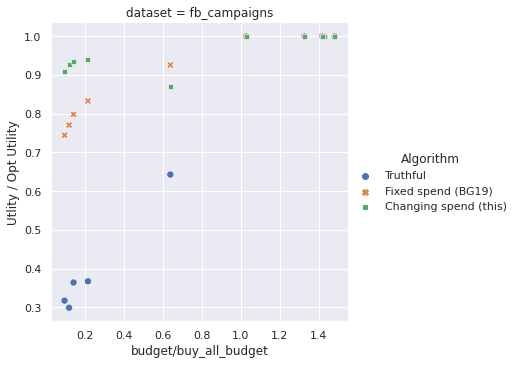

In [262]:
ax = sns.relplot(
    x ='budget_frac',
    y ='fractional_ut',
    kind = 'scatter',
    hue = 'Algorithm',
    style="Algorithm",
    col = "dataset",
    height = 5,
    col_wrap=1,
    data = change_OC(df_utility_res[dataset]),
    s= 50,
    legend = True
    )

ax.set(xlabel='budget/buy_all_budget' , ylabel='Utlity / Opt Utility')
plt.savefig(plot_base + dataset + ".eps",dpi=300, bbox_inches='tight')